In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
import statsmodels.formula.api as smf
import statsmodels.api as sm
from mne.stats import permutation_cluster_1samp_test

from scipy.stats import ttest_1samp, ttest_rel, ttest_ind

import matplotlib.pyplot as plt
import matplotlib.cm as cm

# 1. Frequency tagging
## 1.1 Testing cueing effect on normalized amplitude

In [2]:
# snrs 
participants = ['B1', 'B2', 'B3'] 
ami = []
for participant in participants:
    df_participant = np.load(f'files/{participant}_ami.npy')
    ami.append(df_participant)
ami = np.stack(ami)
ami = pd.DataFrame(ami, columns=['60 & attention_type_block==0',
                                '64 & attention_type_block==0',
                                '60 & attention_type_block==1',
                                '64 & attention_type_block==1'])
ami['participant'] = participants
ami = ami.melt(id_vars='participant')

split_data = ami['variable'].str.split(' & ', expand=True)
ami['frequency'] = split_data[0]
ami['attention'] = split_data[1].str.split('==').str[1]
ami = ami.drop(columns=['variable'])
# Average over stimulation frequencies
ami = ami.groupby(['participant','attention']).value.mean().reset_index()
ami['Attention'] = ami['attention'].replace({'0': 'Exogenous', '1': 'Endogenous'})
ami = ami.drop(columns=['attention'])
ami['Experiment'] = 2

# ADD expe 1
participants = ['A0', 'A1', 'A2'] 
ami_exp1 = []
for participant in participants:
    df_participant = np.load(f'../../my_code_expe1/notebooks/files/{participant}_ami.npy')
    ami_exp1.append(df_participant)
ami_exp1 = np.stack(ami_exp1)
ami_exp1 = pd.DataFrame(ami_exp1, columns=['60','56'])
ami_exp1['participant'] = participants
ami_exp1 = ami_exp1.melt(id_vars='participant')
ami_exp1 = ami_exp1.groupby(['participant']).value.mean().reset_index()
ami_exp1['Attention'] = 'Endogenous'
ami_exp1['Experiment'] = 1

combined = pd.concat([ami, ami_exp1])

Text(48.84883584104938, 0.5, 'Attention modulation index')

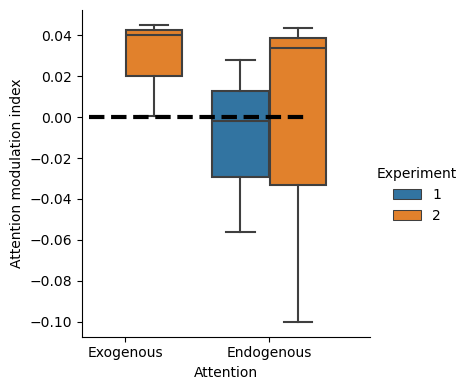

In [3]:
sns.catplot(y='value', x='Attention',  hue='Experiment',
            data=combined, kind='box',  height=4)
plt.hlines(0, -.25, 1.25, color='black', ls='--', lw=3)
plt.ylabel('Attention modulation index')

Text(54.1977822788066, 0.5, 'Attention modulation index')

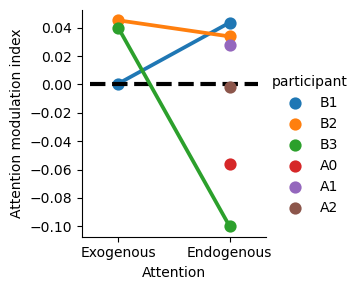

In [4]:
sns.catplot(y='value', x='Attention',  hue='participant',
            data=combined, kind='point',  height=3, errorbar='sd')
plt.hlines(0, -.25, 1.25, color='black', ls='--', lw=3)
plt.ylabel('Attention modulation index')

In [5]:
combined.loc[combined['Attention'] == 'Exogenous', 'Attention'] = 0
combined.loc[combined['Attention'] == 'Endogenous', 'Attention'] = 1
combined['exp_bin'] = combined['Experiment']-1
print(combined)

  participant     value Attention  Experiment  exp_bin
0          B1  0.000508         0           2        1
1          B1  0.043611         1           2        1
2          B2  0.045210         0           2        1
3          B2  0.033835         1           2        1
4          B3  0.040118         0           2        1
5          B3 -0.100128         1           2        1
0          A0 -0.056259         1           1        0
1          A1  0.027846         1           1        0
2          A2 -0.001918         1           1        0


In [6]:
print(f'Exo mean = {combined[(combined.Attention==0) & (combined.Experiment==2)].value.mean()}')
print(f'Exo SD = {combined[(combined.Attention==0) & (combined.Experiment==2)].value.std()}')
print(f'Endo mean = {combined[(combined.Attention==1) & (combined.Experiment==2)].value.mean()}')
print(f'Endo SD = {combined[(combined.Attention==1) & (combined.Experiment==2)].value.std()}')

Exo mean = 0.028611925317644015
Exo SD = 0.02447172303669325
Endo mean = -0.0075606252063248934
Endo SD = 0.08031458930502146


In [7]:
print(f't-test {ttest_1samp(combined[(combined.Attention==0) & (combined.Experiment==2)].value, 0)}')
print(f't-test {ttest_1samp(combined[(combined.Attention==1) & (combined.Experiment==2)].value, 0)}')


t-test TtestResult(statistic=2.0250845548643546, pvalue=0.18013224298578823, df=2)
t-test TtestResult(statistic=-0.1630511605382994, pvalue=0.8854641589062427, df=2)


In [8]:
print(f'Expe 1 mean = {combined[(combined.Attention==1) & (combined.Experiment==1)].value.mean()}')
print(f'Expe 1 SD = {combined[(combined.Attention==1) & (combined.Experiment==1)].value.std()}')
print(f'Expe 2 mean = {combined[(combined.Attention==1) & (combined.Experiment==2)].value.mean()}')
print(f'Expe 2 SD = {combined[(combined.Attention==1) & (combined.Experiment==2)].value.std()}')

Expe 1 mean = -0.010110137334925688
Expe 1 SD = 0.04264686272675085
Expe 2 mean = -0.0075606252063248934
Expe 2 SD = 0.08031458930502146


In [9]:
print(f't-test {ttest_ind(combined[(combined.Attention==1) & (combined.Experiment==1)].value,\
      combined[(combined.Attention==1) & (combined.Experiment==2)].value)}')

t-test TtestResult(statistic=-0.04856084919605514, pvalue=0.9635972448561204, df=4.0)


## 1.2 Coherence analysis

In [10]:
participants = ['B1', 'B2', 'B3'] 

ms_coh = []
for participant in participants:
    df_participant = pd.read_csv(f'files/ITcoh_{participant}.csv', index_col=False)
    df_participant['participant'] = participant
    ms_coh.append(df_participant)
ms_coh = pd.concat(ms_coh)
ms_coh['cued_group'] = (ms_coh['coh_with'] == ms_coh['cued'])
#Average over electrodes
ms_coh = ms_coh.groupby(['participant','condition','time','cued_group']).ITcoherence.mean().reset_index()
ms_coh = ms_coh[(ms_coh.time > -0.1) & (ms_coh.time < 1)]

In [11]:
diff_coh = pd.merge(ms_coh[ms_coh.cued_group == True],
                    ms_coh[ms_coh.cued_group == False], 
                    on=['condition', 'time', 'participant'], suffixes=('_1', '_2'))

# Calculate the difference in ITcoherence
diff_coh['ms_coherence_diff'] = diff_coh['ITcoherence_2'] - diff_coh['ITcoherence_1']
diff_coh['Attention'] = diff_coh['condition'].replace({'exo': 'Exogenous', 'endo': 'Endogenous'})

diff_coh

,participant,condition,time,cued_group_1,ITcoherence_1,cued_group_2,ITcoherence_2,ms_coherence_diff,Attention
0,B1,endo,-0.099609,True,-1.180483,False,-1.255196,-0.074713,Endogenous
1,B1,endo,-0.099121,True,-1.180334,False,-1.253823,-0.073489,Endogenous
2,B1,endo,-0.098633,True,-1.180205,False,-1.252457,-0.072252,Endogenous
3,B1,endo,-0.098145,True,-1.180077,False,-1.251050,-0.070973,Endogenous
4,B1,endo,-0.097656,True,-1.179976,False,-1.249650,-0.069674,Endogenous
...,...,...,...,...,...,...,...,...,...
13507,B3,exo,0.997559,True,1.932957,False,0.631678,-1.301279,Exogenous
13508,B3,exo,0.998047,True,1.935418,False,0.633522,-1.301896,Exogenous
13509,B3,exo,0.998535,True,1.937482,False,0.635375,-1.302107,Exogenous
13510,B3,exo,0.999023,True,1.939323,False,0.637162,-1.302161,Exogenous


/home/lea/anaconda3/envs/ads_thesis/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/lea/anaconda3/envs/ads_thesis/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/lea/anaconda3/envs/ads_thesis/lib/python3.12/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/lea/anaconda3/envs/ads_thesis/lib/python3.12/site-packages/seaborn/_oldcore.py:1075

Using a threshold of 4.302653
stat_fun(H1): min=-2.7000887028350746 max=2.396338447072797
Running initial clustering …
Found 0 clusters
Using a threshold of 4.302653
stat_fun(H1): min=-2.22610820719105 max=7.358296137857985
Running initial clustering …
Found 2 clusters


/tmp/ipykernel_12625/1730581084.py:10: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0 = permutation_cluster_1samp_test(X, n_permutations=1000)


  0%|          | Permuting (exact test) : 0/3 [00:00<?,       ?it/s]

Time at which coherence difference is maximum: 0.13427734375
Time at which coherence difference is maximum: 0.32568359375


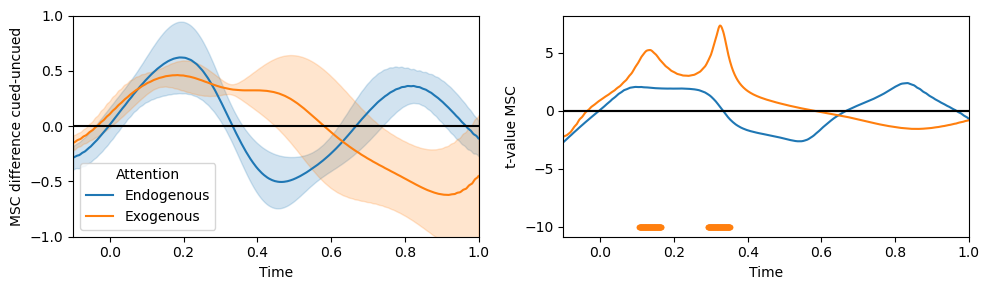

In [12]:
fig, ax = plt.subplots(1,2, figsize=(10,3))
sns.lineplot(y='ms_coherence_diff', hue='Attention', x='time', data=diff_coh, errorbar='se', ax=ax[0])
ax[0].hlines(0, -.1, 1, 'k')
ax[0].set_xlim(-.1, 1)
ax[0].set_ylim(-1, 1)
ax[0].set_ylabel('MSC difference cued-uncued')
ax[0].set_xlabel('Time')

X = diff_coh[diff_coh.Attention == 'Endogenous'].ms_coherence_diff.values.reshape((3, len(diff_coh.time.unique())))
T_obs, clusters, cluster_p_values, H0 = permutation_cluster_1samp_test(X, n_permutations=1000)
ax[1].plot(diff_coh.time.unique(), T_obs, color='tab:blue')
for clust in clusters:
    ax[1].plot(diff_coh.time.unique()[clust[0]], np.repeat(-10, len(clust[0])), '.', color='tab:blue')
    max_T_obs_index = np.argmax(T_obs[clust[0]])
    max_T_obs_time = diff_coh.time.unique()[clust[0][max_T_obs_index]]
    print("Time at which coherence difference is maximum:", max_T_obs_time)
ax[1].hlines(0, -.1, 1, 'k')
ax[1].set_xlim(-.1, 1)
ax[1].set_ylabel('t-value MSC exo-endo')
ax[1].set_xlabel('Time')
plt.tight_layout()
X = diff_coh[diff_coh.Attention == 'Exogenous'].ms_coherence_diff.values.reshape((3, len(diff_coh.time.unique())))
T_obs, clusters, cluster_p_values, H0 = permutation_cluster_1samp_test(X, n_permutations=1000)
for clust in clusters:
    ax[1].plot(diff_coh.time.unique()[clust[0]], np.repeat(-10, len(clust[0])), '.', color='tab:orange')
    max_T_obs_index = np.argmax(T_obs[clust[0]])
    max_T_obs_time = diff_coh.time.unique()[clust[0][max_T_obs_index]]
    print("Time at which coherence difference is maximum:", max_T_obs_time)
ax[1].plot(diff_coh.time.unique(), T_obs, color='tab:orange')
ax[1].hlines(0, -.1, 1, 'k')
ax[1].set_xlim(-.1, 1)
ax[1].set_ylabel('t-value MSC')
ax[1].set_xlabel('Time')
plt.tight_layout()

# 2. Decoding

In [13]:
participants = ['B1', 'B2', 'B3'] 
target_period = []
for participant in participants:
    df_participant = pd.read_csv(f'files/{participant}_target_period_pow.csv', index_col=False)
    df_participant['participant'] = participant
    target_period.append(df_participant)
target_period = pd.concat(target_period)
target_period['Attention'] = target_period['attention'].replace({'exo': 'Exogenous', 'endo': 'Endogenous'})


baseline_period = []
for participant in participants:
    df_participant = pd.read_csv(f'files/{participant}_baseline_pow.csv', index_col=False)
    df_participant['participant'] = participant
    baseline_period.append(df_participant)
baseline_period = pd.concat(baseline_period)

p_value = 1-0.05/len(target_period.time.unique())

# Determine chance level based on best predictor during baseline
chance1, chance99 = np.percentile(baseline_period.groupby(['time']).score.mean(), q=[.1, 99.9])

/home/lea/anaconda3/envs/ads_thesis/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/lea/anaconda3/envs/ads_thesis/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/lea/anaconda3/envs/ads_thesis/lib/python3.12/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/lea/anaconda3/envs/ads_thesis/lib/python3.12/site-packages/seaborn/_oldcore.py:1075

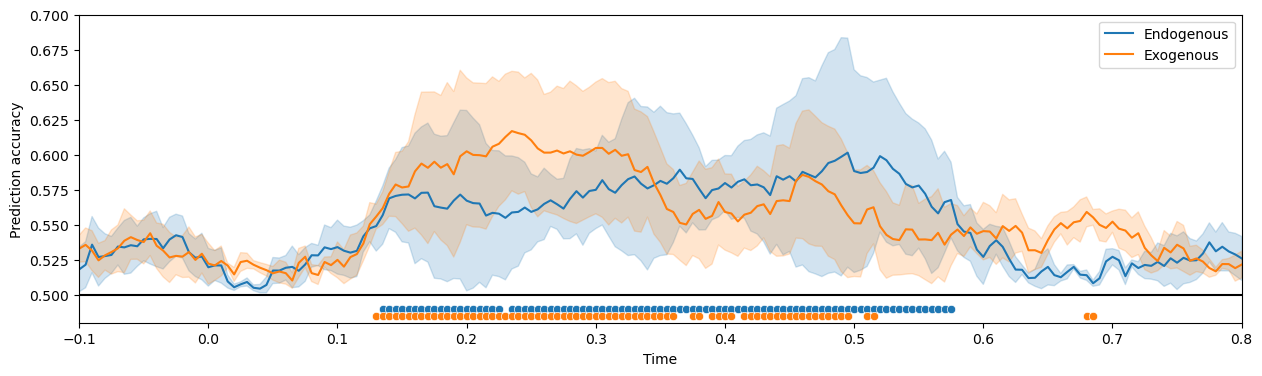

In [14]:
plt.subplots(figsize=(15,4))
sns.lineplot(y='score', hue='Attention', x='time', data=target_period, errorbar='se', hue_order=["Endogenous", "Exogenous"])
plt.hlines(.5, -1, 2.3, 'k')
plt.ylabel('Prediction accuracy')
plt.xlabel('Time')
plt.xlim(-.1,.8)
plt.ylim(.48, .7)

target_period_mean = target_period.groupby(['attention', 'time']).mean('score').reset_index()
higher_than_chance = target_period_mean[ np.round(target_period_mean['score'],2) > np.round(chance99,2)]
for attention, y_val in [('endo', 0.49),('exo', 0.485)]:
    filtered_data = higher_than_chance[higher_than_chance['attention'] == attention]
    sns.scatterplot(x=filtered_data['time'], y=[y_val]*len(filtered_data))


In [15]:
print(f'Best decoding times: {target_period.best_time.unique()}')
print(f'Average best decoding time: {target_period.best_time.unique().mean()}')
print(f'SD best decoding time: {target_period.best_time.unique().std()}')

Best decoding times: [0.485 0.195 0.325]
Average best decoding time: 0.33499999999999996
SD best decoding time: 0.1186029791643813


In [16]:
for participant in participants:
    print(f'Best accuracy {participant}: {target_period[target_period.participant == participant].score.max()}')
print(f'Best accuracy for the averaged predictions: {target_period.groupby(['time']).score.mean().max()}')
print(f'Best accuracy for the averaged predictions for exogeneous: {target_period[target_period.Attention == 'Exogenous'].groupby(['time']).score.mean().max()}')
print(f'Best accuracy for the averaged predictions for endogeneous: {target_period[target_period.Attention == 'Endogenous'].groupby(['time']).score.mean().max()}')

Best accuracy B1: 0.7679841897233202
Best accuracy B2: 0.7179841897233201
Best accuracy B3: 0.6955627705627705
Best accuracy for the averaged predictions: 0.593333427442123
Best accuracy for the averaged predictions for exogeneous: 0.6168787251395947
Best accuracy for the averaged predictions for endogeneous: 0.6014825271347011


In [17]:
higher_than_chance.groupby('attention').time.min()

attention
endo    0.135
exo     0.130
Name: time, dtype: float64